# LGMVIP Task 2 - Stock Market Prediction and Forecasting using Stack LSTM

# Importing libraries

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import tensorflow as tf

# Importing the Dataset

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv")

# Understanding the Dataset

In [8]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [9]:
df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56


# Sorting the dataset according to date

In [10]:
df = df.sort_values(by=['Date'])

In [11]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [12]:
df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35


# Exploring the dataset

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2035 entries, 2034 to 0
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 143.1+ KB


# Setting the cloumn "Close" as the index for prediction

In [18]:
df = df.reset_index()['Close']

# Plotting the data

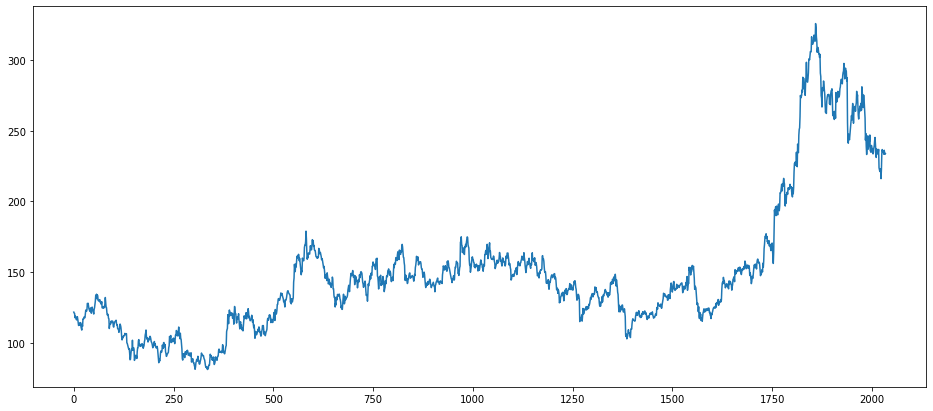

In [25]:
plt.figure(figsize=(16, 7))
plt.plot(df)
plt.show()

# Applying feature scaling to the data

In [71]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(np.array(df).reshape(-1,1))

In [72]:
print(df)

[[0.16584967]
 [0.16319444]
 [0.1621732 ]
 ...
 [0.86383617]
 [0.8698929 ]
 [0.87586945]]


# Splitting into training and testing set

We cant use "from sklearn.model_selection import train_test_split" here since we are only having one variable instead of an independent and a dependent one.

In [30]:
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
trainSet, testSet = df[0:train_size, :], df[train_size:len(df), :1]

# Converting the training and testing data to a dataset array

In [31]:
def datasetGenerator(data, length):
	arr1, arr2 = [], []
	for i in range(len(data)-length-1):  
		arr1.append(data[i:(i + length), 0])
		arr2.append(data[i + length, 0])
	return np.array(arr1), np.array(arr2)

In [32]:
X_train, Y_train = datasetGenerator(trainSet, 100)
X_test, Y_test = datasetGenerator(testSet, 100)

In [33]:
print(X_train)

[[0.16584967 0.16319444 0.1621732  ... 0.14011438 0.13848039 0.12479575]
 [0.16319444 0.1621732  0.14971405 ... 0.13848039 0.12479575 0.12254902]
 [0.1621732  0.14971405 0.15400327 ... 0.12479575 0.12254902 0.13010621]
 ...
 [0.25020425 0.23999183 0.22201797 ... 0.20220588 0.19566993 0.20077614]
 [0.23999183 0.22201797 0.23080065 ... 0.19566993 0.20077614 0.23161765]
 [0.22201797 0.23080065 0.22896242 ... 0.20077614 0.23161765 0.24877451]]


In [34]:
print(Y_train)

[0.12254902 0.13010621 0.13541667 ... 0.23161765 0.24877451 0.25245098]


In [35]:
print(X_test)

[[0.26633987 0.25714869 0.25735294 ... 0.28860294 0.28227124 0.30718954]
 [0.25714869 0.25735294 0.24918301 ... 0.28227124 0.30718954 0.29575163]
 [0.25735294 0.24918301 0.24611928 ... 0.30718954 0.29575163 0.31372549]
 ...
 [0.86519608 0.84027778 0.84497549 ... 0.62888072 0.62765523 0.62234477]
 [0.84027778 0.84497549 0.87111928 ... 0.62765523 0.62234477 0.63378268]
 [0.84497549 0.87111928 0.85273693 ... 0.62234477 0.63378268 0.62622549]]


In [36]:
print(Y_test)

[0.29575163 0.31372549 0.3496732  0.36172386 0.37908497 0.38582516
 0.3809232  0.39236111 0.37908497 0.38480392 0.3690768  0.37275327
 0.36376634 0.36846405 0.37275327 0.35723039 0.36029412 0.3619281
 0.35355392 0.34375    0.3500817  0.34926471 0.36560458 0.34742647
 0.3314951  0.3065768  0.34007353 0.3995098  0.46119281 0.44791667
 0.46343954 0.47058824 0.44485294 0.47222222 0.4628268  0.45894608
 0.44689542 0.47426471 0.47814542 0.47651144 0.45894608 0.47283497
 0.51062092 0.50980392 0.51450163 0.52410131 0.53553922 0.51613562
 0.53553922 0.52941176 0.54064542 0.55249183 0.54227941 0.53615196
 0.49101307 0.47263072 0.50531046 0.48059641 0.49918301 0.51000817
 0.5126634  0.50653595 0.5249183  0.52553105 0.52022059 0.52083333
 0.52471405 0.53533497 0.52818627 0.52553105 0.52839052 0.51409314
 0.50510621 0.49897876 0.52573529 0.50796569 0.52634804 0.57005719
 0.59579248 0.59640523 0.59987745 0.59395425 0.58966503 0.62806373
 0.58843954 0.58639706 0.65155229 0.63398693 0.62683824 0.67708

# Changing column order of inputs to [Samples, Length, Features]

In [37]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Generating the LSTM model

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100, 1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [40]:
model.fit(X_train, Y_train, validation_data = (X_test,Y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
24/24 [==============================] - 10s 224ms/step - loss: 0.0096 - val_loss: 0.0317
Epoch 2/100
24/24 [==============================] - 4s 175ms/step - loss: 0.0017 - val_loss: 0.0071
Epoch 3/100
24/24 [==============================] - 4s 179ms/step - loss: 9.1166e-04 - val_loss: 0.0043
Epoch 4/100
24/24 [==============================] - 4s 177ms/step - loss: 8.3017e-04 - val_loss: 0.0050
Epoch 5/100
24/24 [==============================] - 4s 179ms/step - loss: 8.2446e-04 - val_loss: 0.0047
Epoch 6/100
24/24 [==============================] - 4s 177ms/step - loss: 8.0487e-04 - val_loss: 0.0044
Epoch 7/100
24/24 [==============================] - 4s 175ms/step - loss: 7.3472e-04 - val_loss: 0.0043
Epoch 8/100
24/24 [==============================] - 4s 179ms/step - loss: 7.3308e-04 - val_loss: 0.0037
Epoch 9/100
24/24 [==============================] - 4s 182ms/step - loss: 7.0512e-04 - val_loss: 0.0050
Epoch 10/100
24/24 [==============================] - 4s 178ms

# Making predictions using test data

In [41]:
test_pred = sc.inverse_transform(model.predict(X_test))

# Calculating Root Mean Squared Error for test data and test predictions

In [43]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_test, test_pred))

252.31516654076347

# Plotting the test data predictions

In [45]:
look_back = 100
testPredPlot = np.empty_like(df)
testPredPlot[:, :] = np.nan
testPredPlot[len(X_train) + (look_back*2) + 1:len(df) - 1, :] = test_pred

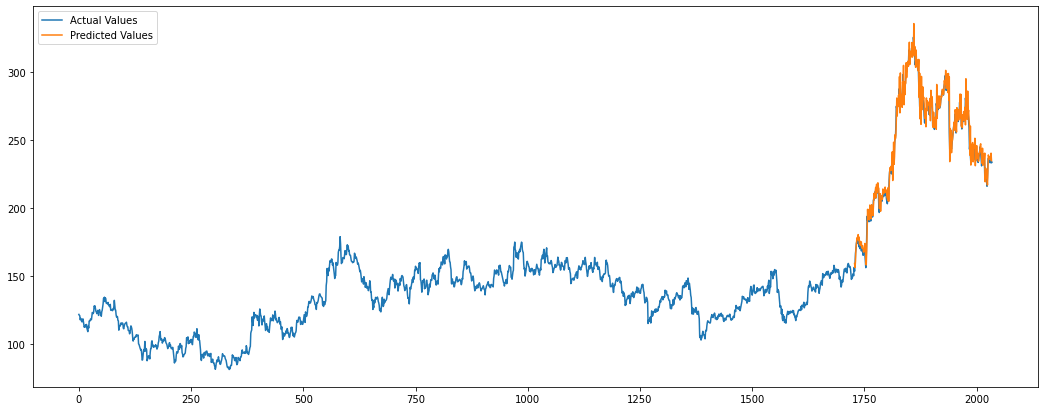

In [50]:
plt.figure(figsize=(18, 7))
plt.plot(sc.inverse_transform(df), label="Actual Values")
plt.plot(testPredPlot, label="Predicted Values")
plt.legend(loc="upper left")
plt.show()

# Using last 100 data values from test data to make prediction for the next 30 days

In [51]:
len(test_data)

407

In [52]:
pred_input = test_data[307:].reshape(1,-1)
pred_input.shape

(1, 100)

In [56]:
tmp = list(pred_input)
tmp = tmp[0].tolist()

In [57]:
print(tmp)

[0.8527369281045751, 0.8621323529411764, 0.8345588235294117, 0.84375, 0.7146650326797386, 0.6605392156862745, 0.6542075163398693, 0.6803513071895424, 0.6689133986928104, 0.6642156862745099, 0.678921568627451, 0.6913807189542482, 0.7089460784313726, 0.7226307189542485, 0.7340686274509802, 0.7212009803921569, 0.749795751633987, 0.7689950980392157, 0.7446895424836601, 0.7120098039215685, 0.7467320261437909, 0.7549019607843137, 0.7604166666666667, 0.7598039215686274, 0.7465277777777777, 0.7624591503267975, 0.7706290849673203, 0.8041258169934642, 0.7810457516339868, 0.7941176470588236, 0.7602124183006536, 0.7348856209150327, 0.7240604575163399, 0.7399918300653596, 0.749795751633987, 0.7614379084967322, 0.7542892156862746, 0.7475490196078431, 0.769607843137255, 0.7495915032679739, 0.8171977124183007, 0.8020833333333335, 0.7773692810457518, 0.7571486928104576, 0.7937091503267975, 0.7916666666666667, 0.7714460784313726, 0.7526552287581698, 0.7269199346405228, 0.6629901960784313, 0.681985294117

# Defining prediction function

In [58]:
output = []
steps=100
i = 0
while (i < 30):
    if(len(tmp) > 100):
        pred_input = np.array(tmp[1:])
        print("Day {} input {}".format(i, pred_input))
        pred_input = pred_input.reshape(1,-1)
        pred_input = pred_input.reshape((1, steps, 1))
        pred = model.predict(pred_input, verbose = 0)
        print("Day {} output {}".format(i, pred))
        tmp.extend(pred[0].tolist())
        tmp = tmp[1:]
        output.extend(pred.tolist())
        i = i + 1
    else:
        pred_input = pred_input.reshape((1, steps, 1))
        pred = model.predict(pred_input, verbose = 0)
        print(pred[0])
        tmp.extend(pred[0].tolist())
        print(len(tmp))
        output.extend(pred.tolist())
        i = i + 1

print(output)

[0.63471705]
101
Day 1 input [0.86213235 0.83455882 0.84375    0.71466503 0.66053922 0.65420752
 0.68035131 0.6689134  0.66421569 0.67892157 0.69138072 0.70894608
 0.72263072 0.73406863 0.72120098 0.74979575 0.7689951  0.74468954
 0.7120098  0.74673203 0.75490196 0.76041667 0.75980392 0.74652778
 0.76245915 0.77062908 0.80412582 0.78104575 0.79411765 0.76021242
 0.73488562 0.72406046 0.73999183 0.74979575 0.76143791 0.75428922
 0.74754902 0.76960784 0.7495915  0.81719771 0.80208333 0.77736928
 0.75714869 0.79370915 0.79166667 0.77144608 0.75265523 0.72691993
 0.6629902  0.68198529 0.64419935 0.62152778 0.6439951  0.66319444
 0.67544935 0.63705065 0.64603758 0.65890523 0.65870098 0.67790033
 0.63194444 0.63112745 0.62785948 0.64767157 0.63991013 0.63480392
 0.63868464 0.62336601 0.62745098 0.63970588 0.64705882 0.66196895
 0.67075163 0.65196078 0.63112745 0.61294935 0.6376634  0.62254902
 0.62745098 0.63337418 0.62642974 0.63623366 0.58312908 0.57781863
 0.57230392 0.58006536 0.57618464

# Plotting the predicted data of 30 days in future.

In [60]:
new_day = np.arange(1, 101)
pred_day = np.arange(101, 131)

In [61]:
len(df)

2035

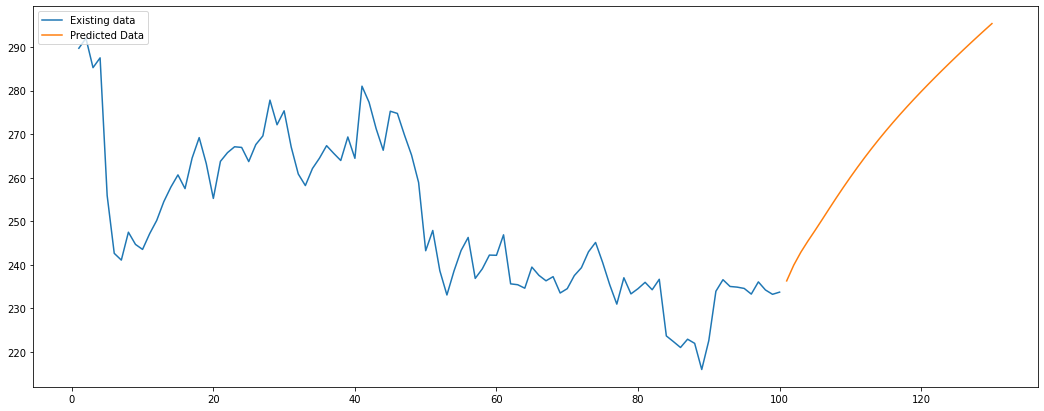

In [63]:
plt.figure(figsize=(18, 7))
plt.plot(new_day, sc.inverse_transform(df[1935:]), label="Existing data")
plt.plot(pred_day, sc.inverse_transform(output), label="Predicted Data")
plt.legend(loc="upper left")
plt.show()